# Problem: Rastrigin function

## Import libraries

In [25]:
# Surpresses printing from other notebook
import io
import sys

original_stdout = sys.stdout
sys.stdout = io.StringIO()
%run genetic_algorithm.ipynb
sys.stdout = original_stdout

In [26]:
import numpy as np
import random
import matplotlib.patches as mpatches
from scipy.spatial.distance import pdist, squareform

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from io import BytesIO
from ipywidgets import widgets
from matplotlib.colors import Normalize
import gymnasium as gym
import seaborn as sns

np.set_printoptions(precision=4, suppress=True) # for better printing
sns.set_style("darkgrid")

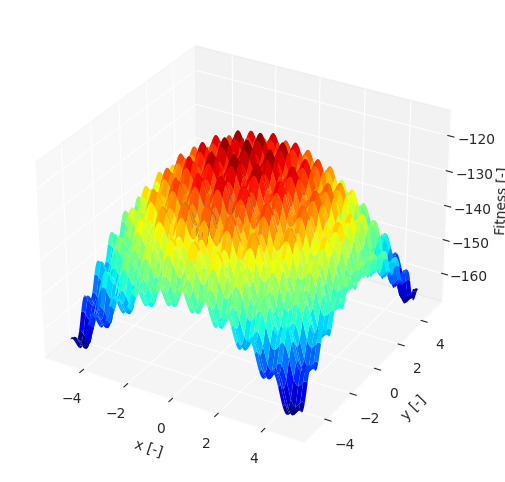

In [28]:
def f_rastrigin(x, y):
    return 80 - (200.0 + x**2 + y**2 - 3.0 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))

r_min, r_max = -5.0, 5.0
xaxis = np.arange(r_min, r_max, 0.01)
yaxis = np.arange(r_min, r_max, 0.01)
x, y = np.meshgrid(xaxis, yaxis)

results = f_rastrigin(x, y)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
ax.patch.set_facecolor('white')
surf = ax.plot_surface(x, y, results, cmap='jet', edgecolor='none')
ax.set_xlabel("x [-]")
ax.set_ylabel("y [-]")
ax.set_zlabel("Fitness [-]")
plt.show()

## Evaluation function
Differently than in the ES exercise, the evaluation of Ackley is not straight-forward. We first have to decode our binary genetic representation in a real-valued phenotype. In our case from the binary string with arbitrary length to two real-valued numbers. Here, we use the binary system and map it to the value space to calculate a real-valued number. With more chromosomes, we can reach a higher precision.

> **Note**: We use this mapping out of convience for this exercise. GA could learn - theoretically - arbitrary bijective mappings.

In [29]:
def decode_chromosomes(chromosome):
    lb_x, ub_x = -5, 5
    lb_y, ub_y = -5, 5

    len_half = len(chromosome) // 2
    chrom_x = chromosome[:len_half]
    chrom_y = chromosome[len_half:]
    
    # Calculate the precision
    precision_x = (ub_x - lb_x) / ((2 ** len_half) - 1)
    precision_y = (ub_y - lb_y) / ((2 ** len_half) - 1)
    
    # Convert binary arrays to integers using dot product for efficient computation
    x_int = np.dot(chrom_x, 2**np.arange(len_half)[::-1])
    y_int = np.dot(chrom_y, 2**np.arange(len_half)[::-1])

    # Scale the integers to the desired range
    x = (x_int * precision_x) + lb_x
    y = (y_int * precision_y) + lb_y
    
    return x, y

In [30]:
# Test function:
population = generate_initial_population(5, 100)

chromosome = population[0,:]
print(f"Chromosome encoding:\n{chromosome}")
print(f"Real-value:\n{decode_chromosomes(chromosome)}")

Chromosome encoding:
[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0
 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1]
Real-value:
(2.9138481670045717, 0.7248058713235892)


After decoding, we can evaluate as usally.

In [31]:
def f_rastrigin(x, y):
    fitness = 80 - (200.0 + x**2 + y**2 - 3.0 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
    return fitness

print(f"Maximum {f_rastrigin(0, 0)} at (0, 0)")

Maximum -114.0 at (0, 0)


In [32]:
def evaluate_population_rastrigin(population):
    population_size = population.shape[0]
    fitness = np.zeros((population_size,))
        
    for i in range(population_size):
        chromosomes = population[i, :]
        x, y = decode_chromosomes(chromosomes)
        fitness[i] = f_rastrigin(x,y)
    
    return fitness

In [33]:
# Test function:
population = generate_initial_population(20, 100)
fitness = evaluate_population_rastrigin(population)
print(f"Fitness: {fitness}")

Fitness: [-128.6398 -116.9694 -149.0926 -136.1413 -146.3835 -125.7804 -122.5414
 -138.8567 -147.6125 -132.3751 -145.202  -119.4517 -120.4176 -139.2738
 -149.2977 -121.363  -120.8233 -129.6058 -130.0397 -140.0492]


## Evolution

-------
## **Questions**
Provide written answers for the following questions:
1. Run the GA code using the default parameters and see if the GA finds the global minimum. How many generations does it take to converge?
2. How does using mutation alone (`crossover_probability` = 0) and crossover alone (`mutation_probability` = 0) influence the results? What about if you use a small or a large population size?
3. What happens if you use a larger magnitude mutation probability (`mutation_probability`)?
4. What happens if the tournament size is small (minimal is 2) or large (`tournament_size` must still be less than `population_size`)?
5. Turn on the learning schedule by decreasing the `sigma_decay` parameter? How does this influence the diversity of the population?

-------

In [34]:
# Environment parameters
num_generations = 100
population_size = 40 # only even numbers!

# ES parameters
chromosome_length = 30
tournament_size = 10
crossover_probability = 0.4
mutation_probability = 0.15

# Learning schedule
sigma_decay = 1.00 # [0.0, 1.0]
sigma_limit = 0.01

# Logging
diversity_type = "hamming"

fitness_log = []
diversity_metric = []

# Parameter check
assert tournament_size < population_size
assert 0.0 <= crossover_probability <= 1.0
assert 0.0 <= mutation_probability <= 1.0
assert 0.0 <= sigma_decay <= 1.0
assert 0.0 <= sigma_limit <= 1.0
assert population_size % 2 == 0

# Control of mutation rate
def exp_decay(sigma, sigma_decay, sigma_limit):
    sigma = sigma * sigma_decay
    return np.max((sigma_limit, sigma))

population = generate_initial_population(population_size, chromosome_length)
for gen in range(num_generations):
    # Evaluate fitness of population
    fitness = evaluate_population_rastrigin(population)

    # Generate new population
    offspring = np.zeros((population_size, chromosome_length))
    
    # "Survival-of-the-fittest"
    for i in range(int(population_size/2)):
        # Tournament
        parent_1 = tournament_selection(population, fitness, tournament_size)
        parent_2 = tournament_selection(population, fitness, tournament_size)
        
        child_1, child_2 = stochastic_one_point_crossover(
            parent_1, parent_2, crossover_probability
        )
        
        offspring[i,:] = child_1
        offspring[i+int(population_size/2), :] = child_2
    
    # Ensure that datatype is fitting
    offspring = offspring.astype(int)
    
    # Generation undergoes mutation
    mutated_offspring = mutate_genotypes(offspring, mutation_probability)
    
    # Generational Replacement
    population = mutated_offspring
    
    # Decaying mutation rate
    mutation_probability = exp_decay(mutation_probability, sigma_decay, sigma_limit)
    
    # Logging
    fitness_log.append(fitness)
    distances = squareform(pdist(offspring, metric='hamming'))
    diversity_score = np.sum(distances)
    
    diversity_metric.append(diversity_score)
    
    if gen % 5 == 0:
        print(f"Max fitness at gen {gen}: {max(fitness)}")
    

Max fitness at gen 0: -116.66916938830587
Max fitness at gen 5: -114.62548497013933
Max fitness at gen 10: -114.00511679034699
Max fitness at gen 15: -114.13099511693241
Max fitness at gen 20: -114.39891433998406
Max fitness at gen 25: -115.12309289244416
Max fitness at gen 30: -114.03112577218499
Max fitness at gen 35: -114.15547879801196
Max fitness at gen 40: -114.00193200994858
Max fitness at gen 45: -114.03070415149062
Max fitness at gen 50: -114.07385775325486
Max fitness at gen 55: -114.03563123275231
Max fitness at gen 60: -114.07840198706035
Max fitness at gen 65: -114.24551461998189
Max fitness at gen 70: -114.22288248814411
Max fitness at gen 75: -114.04023375975183
Max fitness at gen 80: -114.15682730758346
Max fitness at gen 85: -114.02309375234128
Max fitness at gen 90: -114.02643703372175
Max fitness at gen 95: -114.23345000707678


# Visualise results

## Fitness Graph

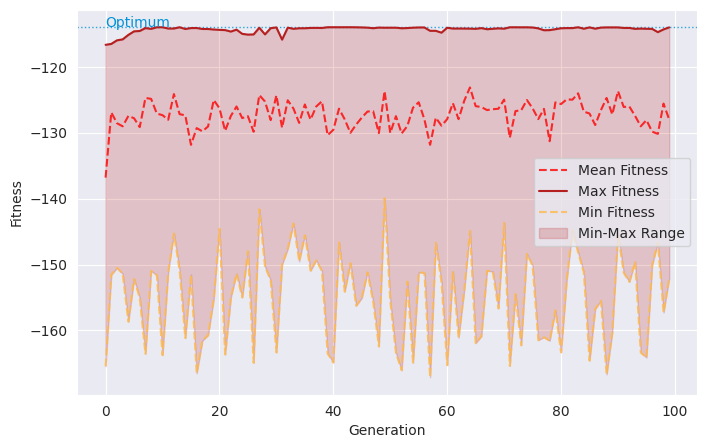

In [35]:
# Calculate mean, min, and max fitness for each generation
mean_fitness = np.mean(fitness_log, axis=1)
min_fitness = np.min(fitness_log, axis=1)
max_fitness = np.max(fitness_log, axis=1)

# Generate the generations array
generations = np.arange(len(mean_fitness))

# Plotting
plt.figure(figsize=(8, 5))

plt.annotate("Optimum", xy= (0, f_rastrigin(0.0, 0.0)), color="#0193d7")
plt.axhline(y=f_rastrigin(0.0, 0.0), linestyle="dotted", linewidth=1.0, alpha=0.8, color="#0193d7")
plt.plot(generations, mean_fitness, label='Mean Fitness', linestyle="dashed", color="#FF0000", alpha=0.8)
plt.plot(generations, max_fitness, label='Max Fitness', color="#B51F1F")
plt.plot(generations, min_fitness, label='Min Fitness', linestyle="dashed", color="#ffba4d", alpha=0.8)

plt.fill_between(generations, min_fitness, max_fitness, color="#B51F1F", alpha=0.2, label='Min-Max Range')

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

## Diversity of genotype using Hamming distance

Hamming distance is used in information theory to evaluate the similarity of symbols and is especially useful for binary information. It measures the minimum number of substitutions required to change one string into the other.

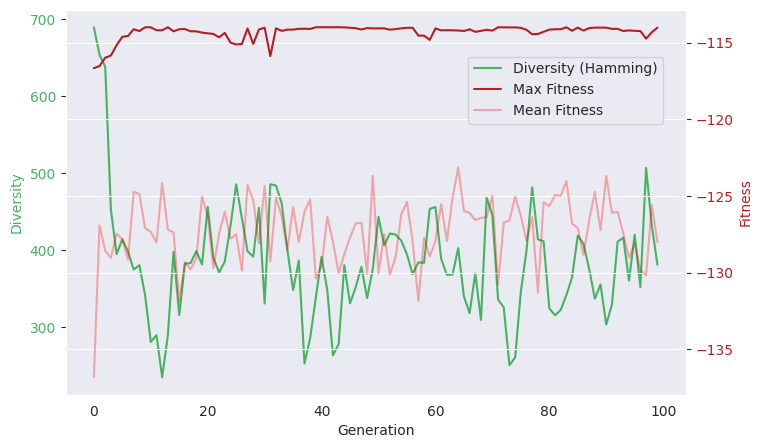

In [36]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plotting the diversity data
diversity_metric = np.array(diversity_metric)
color = "#46b361"
ax1.set_xlabel('Generation')
ax1.set_ylabel('Diversity', color=color)
ax1.plot(diversity_metric, color=color, label="Diversity (Hamming)")
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for fitness data
max_fitness = np.max(fitness_log, axis=1)
mean_fitness = np.mean(fitness_log, axis=1)

ax2 = ax1.twinx()  
color = "#B51F1F"
ax2.set_ylabel('Fitness', color=color)
ax2.plot(max_fitness, color=color, label="Max Fitness")
ax2.plot(mean_fitness, color="#FF0000", label="Mean Fitness", alpha=0.3)
ax2.tick_params(axis='y', labelcolor=color)

# Adding title and grid
ax1.grid(False)
ax2.grid(True)
fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.8))

# Display the plot
plt.show()